# Traveling Salesman Problem via Genetic algorithms

Francesco Andreuzzi -- Data Science and Scientific Computing

Final project for the course "Computational Physics Laboratory" (2022/2023)

## The problem

The Traveling Salesman Problem (TSP) is a well known problem in Computer Science. It consists in finding the optimal (i.e. cheapest) tour which visits all cities in the instance, given a matrix of costs to travel from one to another. 
$$
\normalsize
\begin{align*}
\text{Minimize}& \qquad \sum_{i=1}^N \sum_{j=1}^N x_{ij} d_{ij} \\
\text{with}& \qquad \sum_{j=1}^N x_{ij} = 1 \qquad i = 1, \dots N \quad (\text{Exactly one incoming})\\
& \qquad \sum_{i=1}^N x_{ij} = 1 \qquad j = 1 \dots N \quad (\text{Exactly one outgoing})
\end{align*}
$$

It's NP-hard, therefore exact algorithms are unfeasible for non-trivial instances.

## Genetic algorithms overview

Genetic algorithms (GA) are approximation randomized algorithms which iteratively optimize a partial set of viable solutions to a given problem, often called *chromosomes*. The optimization is carried out on a given *fitness* function, which in our case is the cost of a given tour.

Optimization happens by a peculiar process called *crossover*, which consists in merging two parent solutions into a new one, hopefully retained the best parts of the ancestors. Many *crossover operators* exist for the TSP problem, some of them are fully deterministic (e.g. `CX`, `CX2`), while others are based on a stochastic component (e.g. `OX`, `PMX`).

In addition to crossover, to further mimic natural biological evolution, GA leverage *mutation* to slightly modify a subset of exising chromosomes (choosed randomly). This often provides solutions not easily achievable by means of crossover, and is critical in fully exploring the solution manifold. Due to their intrinsic stochastic definition, mutation operator are always randomized procedures which operate on a single chromosome.

## Structure of the project

We briefly describe the structure of the GitHub repository.

### Languages

The problem was tackled using Python and Fortran 90, leveraging [f2py](https://numpy.org/doc/stable/f2py/index.html) to link the two languages. Python was used to develop the high level driver for the genetic framework, the problem loading and the data collection layer, and to perform final data analysis, due to its strong versatility. Fortran was used to develop the low-level mutation and crossover operators.

Thanks to the link between Python and Fortran it has been possible to test the fortran code by using the high level Python testing framework [pytest](https://pytest.org), which among standard testing traits provides many comfortable features like a rich CLI and [fixtures](https://docs.pytest.org/en/6.2.x/fixture.html).

### Directories

```diff
$ tree -I 'venv|__pycache__|*.mod' --dirsfirst
.
├── data
-   │   # Problem data in XML format
│   │   ...
├── data-loader
-   │   # Responsible for loading problem data from XML
│   ├── load.py
-   │   # Problem representation as a Python class
│   └── problem.py
├── run
-   │   # Argparse CLI + utilities (logging, text display)
│   ├── data_storage.py
│   ├── printer.py
│   ├── run.py
│   └── utils.py
├── tests
-   │   # Pytest testing for low-level Fortran routines
│   ├── crossover
│   │   ├── test_crossover.py
│   │   ├── test_cx2-original.py
│   │   ├── test_cx2.py
│   │   ├── test_cx.py
│   │   ├── test_ox.py
│   │   └── test_pmx.py
│   ├── mutation
│   │   ├── test_central_inverse.py
│   │   ├── test_mutation.py
│   │   ├── test_reverse_sequence.py
│   │   └── test_twors.py
│   ├── test_problem.py
│   └── test_utils.py
├── tsp-genetic-f90
-   │   # Fortran implementation of low-level operators
│   ├── crossover
│   │   ├── cx2.f90
│   │   ├── cx2-original.f90
│   │   ├── cx.f90
│   │   ├── ox.f90
│   │   └── pmx.f90
│   ├── mutation
│   │   ├── central_inverse.f90
│   │   ├── reverse_sequence.f90
│   │   └── twors.f90
│   ├── problem.f90
│   └── utils.f90
├── tsp-genetic-py
-   │   # Genetic framework implementation
│   ├── configuration.py
│   ├── crossover.py
│   ├── evolve.py
│   ├── idata_logger.py
│   └── mutation.py
├── LICENSE
├── Makefile
├── README.md
-   # We are here
├── tsp-genetic-algorithms.ipynb
-   # Fortran code compiled with f2py
└── tsp_genetic.cpython-39-x86_64-linux-gnu.so
```

In [1]:
import sys
from pathlib import Path

sys.path.append("tsp-genetic-py")
from configuration import Configuration

# High level objects
We defined some high level objects to ease starting a genetic optimization run.

In [2]:
import sys
from pathlib import Path
sys.path.append("tsp-genetic-py")
sys.path.append("data-loader")
sys.path.append("run")

## Problem object
TSP problems are taken from the [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/) repository, and are stored in the directory `data/` of the project. We represent them in Python with the [dataclass](https://docs.python.org/3/library/dataclasses.html) `Problem`, which contains the fields `name`, `cost_matrix` and `optimal_tour`.

In [3]:
from load import build_problem

build_problem("a280")

Problem(name='a280', cost_matrix=array([[20.        , 24.08318916, 32.984845  , ..., 43.26661531,
        34.40930107, 17.88854382],
       [20.        , 18.43908891, 34.17601498, ..., 36.22154055,
        28.        ,  8.94427191],
       [24.08318916, 18.43908891, 16.1245155 , ..., 19.6977156 ,
        10.77032961, 10.        ],
       ...,
       [43.26661531, 36.22154055, 19.6977156 , ..., 17.08800749,
         8.94427191, 29.12043956],
       [34.40930107, 28.        , 10.77032961, ..., 18.43908891,
         8.94427191, 20.39607805],
       [17.88854382,  8.94427191, 10.        , ..., 34.92849839,
        29.12043956, 20.39607805]]), optimal_tour=array([  1,   2, 242, 243, 244, 241, 240, 239, 238, 237, 236, 235, 234,
       233, 232, 231, 246, 245, 247, 250, 251, 230, 229, 228, 227, 226,
       225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213,
       212, 211, 210, 207, 206, 205, 204, 203, 202, 201, 198, 197, 196,
       195, 194, 193, 192, 191, 190, 189, 188, 187, 

## Configuration

We defined the dataclass `Configuration` to pack all needed configurations for a given genetic optimization run:

In [4]:
from configuration import Configuration
from dataclasses import fields

[field.name for field in fields(Configuration)]

['population_size',
 'elite_size',
 'n_generations',
 'mutation_operator',
 'mutation_probability',
 'mutation_function_degree',
 'crossover_operator',
 'crossover_strategy',
 'crossover_retainment',
 'next_generation_policy',
 'print_every']

# Genetic optimization

- Crossover operators
- Crossover strategy
- Mutation operators
- Mutation probability evolution
- Next generation policy & elitism

## Crossover operators

First of all we need to define configurations for all the run we intend to perform.

In [5]:
from dataclasses import replace
from configuration import (
    Crossover,
    CrossoverStrategy,
    CrossoverRetainment,
    NextGenerationPolicy,
)
from mutation import Mutation

base_config = Configuration(
    population_size=500,
    elite_size=0,
    n_generations=1000,
    crossover_operator=None,
    crossover_strategy=CrossoverStrategy.FITNESS_RANDOM_PAIRS,
    crossover_retainment=CrossoverRetainment.FIRST,
    next_generation_policy=NextGenerationPolicy.BEST,
    mutation_operator=Mutation.TWORS,
    mutation_probability=0.01,
    mutation_function_degree=0,
    print_every=100,
)
ox_config = replace(base_config, crossover_operator=Crossover.OX)
pmx_config = replace(base_config, crossover_operator=Crossover.PMX)
cx_config = replace(base_config, crossover_operator=Crossover.CX)
cx2_config = replace(base_config, crossover_operator=Crossover.CX2)

Then we use the function `driver` to run a genetic optimization run, passing in a `DataStorage` to keep some values for later inspection of the results.

In [6]:
from data_storage import DataStorage
from evolve import driver

problem = build_problem("a280")

def run(config):
    logger = DataStorage()
    driver(problem, ox_config, logger)
    return logger

ox_data = run(ox_config)
pmx_data = run(pmx_config)
cx_data = run(cx_config)
cx2_data = run(cx2_config)

The following results are relative to a single run, for each crossover operator.

In [7]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

def setup_matplotlib():
    mpl.rcParams.update(mpl.rcParamsDefault)
    matplotlib.rc('font', size=16)

import numpy as np

x = base_config.print_every * np.arange(len(ox_data.fitness_best))

def get_color(plot):
    return plot[0].get_color()

def plot_std(data, color):
    plt.fill_between(x, data.fitness_mean - data.fitness_std, data.fitness_mean + data.fitness_std, color=color, alpha=0.3)

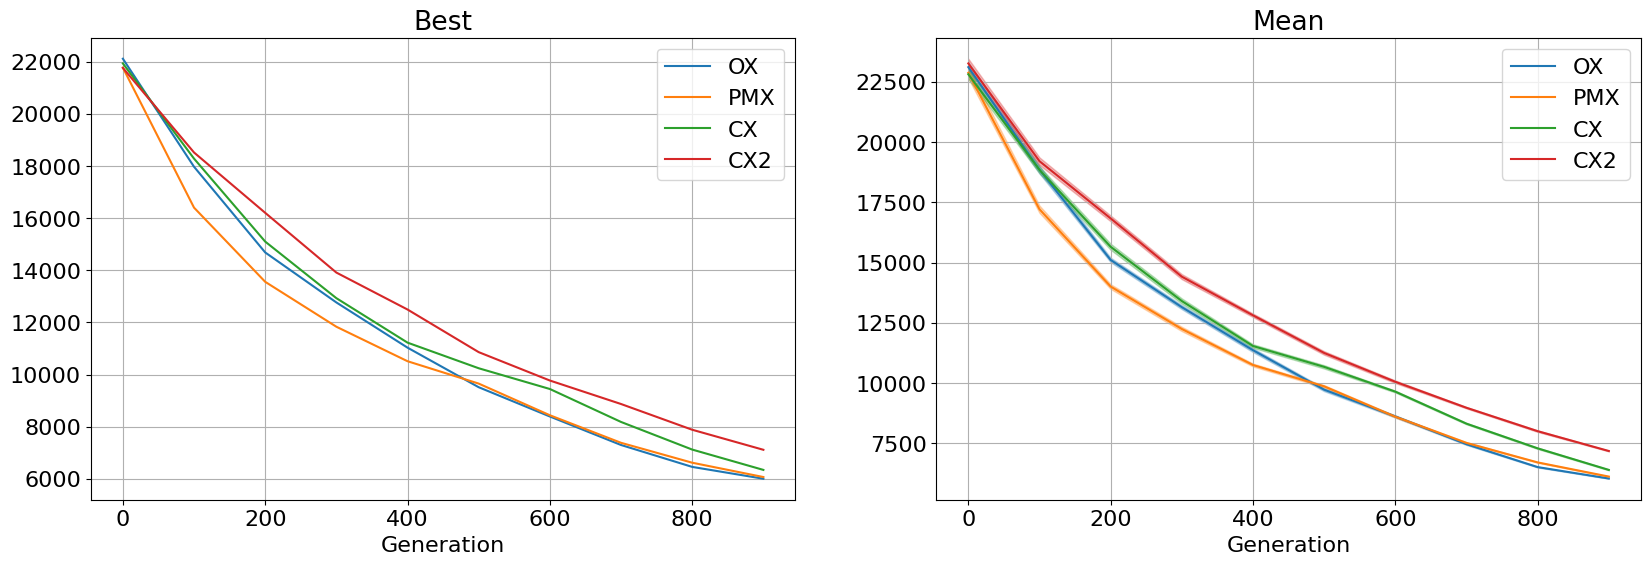

In [13]:
def plot_data(datas, labels):
    setup_matplotlib()
    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    colors = [get_color(plt.plot(x, data.fitness_best, label=label)) for data, label in zip(datas, labels)]

    plt.title("Best")
    plt.legend()
    plt.xlabel("Generation")
    plt.grid()

    plt.subplot(1,2,2)
    for data, label, color in zip(datas, labels, colors):
        plt.plot(x, data.fitness_mean, color, label=label)
        plot_std(data, color)

    plt.title("Mean")
    plt.legend()
    plt.xlabel("Generation")
    plt.grid()

    plt.show()
    
plot_data((ox_data, pmx_data, cx_data, cx2_data), ("OX", "PMX", "CX", "CX2"))

## Mutation evolution

As noted in [6], it's desirable to increase the mutation probability as the generation index increases, since the population of chromosomes tends to stagnate towards repeated high-fitness individuals. For this reason, extending the work presented in [6], we implemented a flexible evolution policy for the mutation probability, i.e. the probability that a given chromosome is subject to a mutation after crossover happens. The policy is parametrized by an integer number $k$, which acts as the polynomial degree of the function which describes the evolution of the probability in time.

The mutation probability $m$ for the generation $g$ is computed as follows:
$$
\normalsize
m(g) = \frac{M}{G^k} g^k
$$

given the total number of generations $G$ and the target mutation probability $M$.

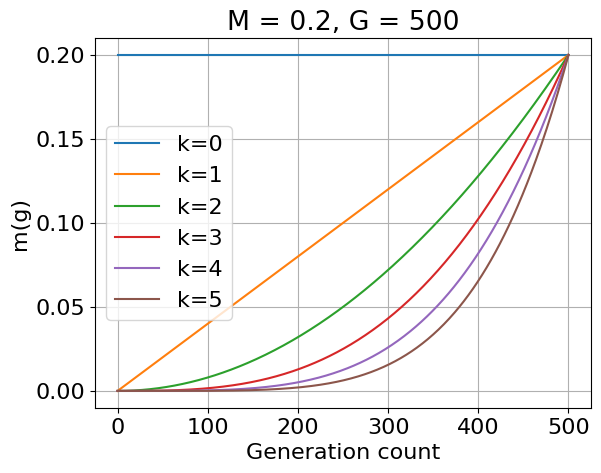

In [19]:
g = np.arange(501)
M = 0.2

def plot_evolution(k):
    plt.plot(g, M / g[-1]**k * g**k, label=f"k={k}")
    
for i in range(6):
    plot_evolution(i)
    
plt.legend()

plt.xlabel("Generation count")
plt.ylabel("m(g)")
plt.title(f"M = {M}, G = {g[-1]}")
plt.grid()

plt.show()

## Implementation of `CX2`

The MATLAB code in [3] proposed as the official implementation of `CX2` is clearly inefficient due to the frequent restort to the `find()` function, which is $\Theta(N)$. Since the crossover requires a linear scan of the array, the implementation in [3] is $\Theta(N^2)$.

For this reason we re-implemented it by leveraging a pre-built index, which makes the function $\Theta(N)$.

Output()

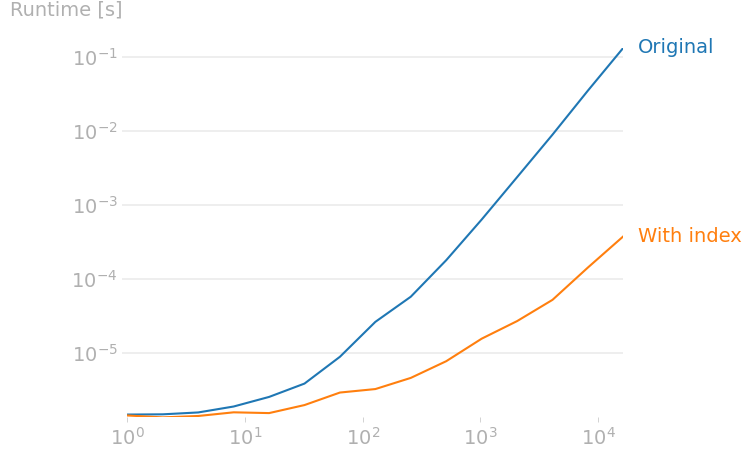

In [10]:
from tsp_genetic import cx2, cx2_original
import perfplot

perfplot.show(
    setup=lambda n: ((np.random.permutation(n) + 1, np.random.permutation(n) + 1),),
    kernels=[
        lambda a: cx2_original(*a),
        lambda a: cx2(*a),
    ],
    labels=["Original", "With index"],
    n_range=[2**k for k in range(15)],
    show_progress=False,
)

setup_matplotlib()

# Conclusion

## Unexplored directions

It could be interesting to take into account various ways to generate the initial generation of chromosomes. In this project we've only considered the randomized permutation of the list of cities, but more refined approaches exist to guarantee a better coverage on the solution manifold.

## References

1. Deep, Kusum, and Hadush Mebrahtu. "New variations of order crossover for travelling salesman problem." International Journal of Combinatorial Optimization Problems and Informatics 2.1 (2011): 2-13.
1. Potvin, Jean-Yves. "Genetic algorithms for the traveling salesman problem." Annals of Operations Research 63 (1996): 337-370.
1. Hussain, Abid, et al. "Genetic algorithm for traveling salesman problem with modified cycle crossover operator." Computational intelligence and neuroscience 2017 (2017).
1. Kumar, Rakesh, Girdhar Gopal, and Rajesh Kumar. "Novel crossover operator for genetic algorithm for permutation problems." International Journal of Soft Computing and Engineering (IJSCE) 3.2 (2013): 252-258.
1. Abdoun, Otman, Jaafar Abouchabaka, and Chakir Tajani. "Analyzing the performance of mutation operators to solve the travelling salesman problem." arXiv preprint arXiv:1203.3099 (2012).
1. Hassanat, Ahmad, et al. "Choosing mutation and crossover ratios for genetic algorithms—a review with a new dynamic approach." Information 10.12 (2019): 390.
1. f2py official documentation: https://numpy.org/doc/stable/f2py/

## Open source software

- argparse: https://docs.python.org/3/library/argparse.html
- f2py: https://numpy.org/doc/stable/f2py/
- Matplotlib: https://matplotlib.org
- NumPy: https://numpy.org
- Python standard library: https://docs.python.org/3/library/
- pytest: https://pytest.org
- perfplot: https://github.com/nschloe/perfplot